# Heart Disease Prediction Part 1: Building the model

## Overview

The first part of this project is build a model that can predict the likelihood of developing heart disease based on some factors.

This notebook is divided into the following segments:
1. Downloading and reading the data
2. Cleaning and Exploratory Analysis
3. Preprocessing and Modelling
4. Feature Importance and Model Explainability

## Problem Statement

There is a need to be able to predict the likelihood of developing heart disease, and also identify the combination of factors that increase the likelihood of developing heart disease. Hence this notebook will do two things, 
1. Build a model to predict the likelihood of developing heart disease
2. Identify the risk factors

## Methodology and Approach

The following summerise the methodology as used in this notebook
1. **Binary Classification**: This project will be approached from a binary classification persperctive, being that we are predicting yes or no. 
2. **Method of evaluation**: Hold-out-validation, model will be evaluated with a hold out set. This is meant to in a way similate unseen data. 
3. **Evaluation Metrics**: Our predictions need to be as correct as possible. For this reason, we will be using precision score to evaluate our model. We will also support this with a confusion matrix, to show the amount of correct and wrong predictions. 
4. **Choosing the right model**: We will be benchmarking three algorithms against each other. 

## 1. Downloading and Reading the data from Kaggle

We will be downloading the data from kaggle using it's API command

In [1]:
# --- download zipped file from kaggle with kaggle API command
# !kaggle datasets download --force 'kamilpytlak/personal-key-indicators-of-heart-disease'

In [2]:
# --- unzip the zipped file to access the dataset. 
# --- This command downloads unzips file in working directory
# !unzip personal-key-indicators-of-heart-disease.zip

In [62]:
# --- importing and setting dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors 
import matplotlib.patheffects as path_effects

from IPython.display import display, Markdown, Latex
from matplotlib import cm

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.calibration import calibration_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn import set_config

# --- classifiers
gbc_clf = GradientBoostingClassifier(random_state = 42)
rfc_clf = RandomForestClassifier(random_state = 42)
log_reg = LogisticRegression(solver = 'liblinear', random_state = 42)
dt_clf = DecisionTreeClassifier(random_state = 42)

# --- imblearn oversampling and undersampling for class balancing
over = RandomOverSampler(sampling_strategy= 'minority')
under = RandomUnderSampler(sampling_strategy= 'majority')
steps = [('o', over), ('u', under)]
class_balancer = Pipeline(steps=steps)

# --- preprocessing algorithms
one_hot_encoder = OneHotEncoder(handle_unknown = 'ignore')
ordinal_encoder = OrdinalEncoder()
LabelEncoder = LabelEncoder()

sns.set_theme()
set_config(display='diagram')

In [63]:
# --- reading file with pandas and viewing with df.head()
df = pd.read_csv('heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## 2. Cleaning and Exploring the data

Here we will be checking for and filling null values (if any), finding and treating outliers if any, getting the data types of columns, conducting some feature engineering and visualizing the data based on some questions. 

Since we are trying to identify risk factors, our visualization will be guided by this questions
1. How early or late do people with heart disease sleep?
2. Do Concerns about mental, physical health increase the likelihood of heart disease
3. Does physical activity increase the likelihood of heart disease? 
4. What gender is likely to develop heart disease?
5. At what ages do men and women mostly develop heart disease?
6. Do smoking and alcohol usage increase the likelihood of heart disease? 
7. Does kidney disease or skin cancer lead to heart disease? 
8. What has BMI got to do with heart disease? 

In [64]:
# --- datatypes of columns in our dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [65]:
# --- thankfully, no nulls in our data

print('shape of dataset:', df.shape)
print()
print('nulls in dataset by column:', '\n', df.isnull().sum())

shape of dataset: (319795, 18)

nulls in dataset by column: 
 HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


In [66]:
def get_datatype(df = df, datatype = 'object'):
    """
    function to get columns with specified datatype
    """
    return df.select_dtypes(include = datatype)

cat_variables = get_datatype(df = df, datatype = 'object')
num_variables = get_datatype(df = df, datatype = 'number')

In [67]:
for column in cat_variables.columns.tolist():
    print(column)
    print(dict(df[column].value_counts()))
    print('\n')

HeartDisease
{'No': 292422, 'Yes': 27373}


Smoking
{'No': 187887, 'Yes': 131908}


AlcoholDrinking
{'No': 298018, 'Yes': 21777}


Stroke
{'No': 307726, 'Yes': 12069}


DiffWalking
{'No': 275385, 'Yes': 44410}


Sex
{'Female': 167805, 'Male': 151990}


AgeCategory
{'65-69': 34151, '60-64': 33686, '70-74': 31065, '55-59': 29757, '50-54': 25382, '80 or older': 24153, '45-49': 21791, '75-79': 21482, '18-24': 21064, '40-44': 21006, '35-39': 20550, '30-34': 18753, '25-29': 16955}


Race
{'White': 245212, 'Hispanic': 27446, 'Black': 22939, 'Other': 10928, 'Asian': 8068, 'American Indian/Alaskan Native': 5202}


Diabetic
{'No': 269653, 'Yes': 40802, 'No, borderline diabetes': 6781, 'Yes (during pregnancy)': 2559}


PhysicalActivity
{'Yes': 247957, 'No': 71838}


GenHealth
{'Very good': 113858, 'Good': 93129, 'Excellent': 66842, 'Fair': 34677, 'Poor': 11289}


Asthma
{'No': 276923, 'Yes': 42872}


KidneyDisease
{'No': 308016, 'Yes': 11779}


SkinCancer
{'No': 289976, 'Yes': 29819}




In [68]:
num_variables.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


#### Some Observations

The data is made up of a combination of numerical and categorical attributes and there are no nulls. Additionaly, there are some outliers in the data. But we will only be rectifying the BMI outliers, because it's not possible to have a BMI of 94. Other columns can remain as they are. 

In [69]:
# --- checking the skewness of the BMI column

print(df['BMI'].skew())

1.3324306428979513


In [70]:
# --- rectifying outliers in the BMI column
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1

outliers = num_variables['BMI'][(num_variables['BMI'] < (Q1 - 1.5 * IQR)) |(num_variables['BMI'] > (Q3 + 1.5 * IQR))]
df.drop(df['BMI'][outliers.index].index, axis = 0, inplace = True)

# --- checking the skewness of the BMI column after dropping outliers

print(df['BMI'].skew())

0.47363790026102703


In [71]:
df.shape

(309399, 18)

### Feature Engineering

Here we will be extracting features from existing ones. Essentially, we will be binning the numerical columns in the data to give us some ordinal variables for easy visualization. For example, from BMI, we can identify those who are underweight, normal, overweight and extremely obese

In [72]:
# --- binning BMI
def discretize_bmi(bmi_index):
    
    bmi_level = ''
    if bmi_index >= 0 and bmi_index <= 18:
        bmi_level = 'underweight'
    if bmi_index > 18 and bmi_index <= 24:
        bmi_level = 'normal'
    if bmi_index > 24 and bmi_index <= 29:
        bmi_level = 'overweight'
    if bmi_index > 29 and bmi_index <= 39:
        bmi_level = 'obese'
    if bmi_index > 39:
        bmi_level = 'extremely obese'
        
    return bmi_level
    
    
df['weight_status_by_bmi'] = df['BMI'].apply(lambda x: discretize_bmi(x))



# ---binning physical and mental health
def get_health_concern(index):
    
    health_status = ''
    
    if index >= 0 and index <= 5:
        health_status = 'rarely concerned'
    if index > 5 and index <= 15:
        health_status = 'often concerned'
    if index > 15: 
        health_status = 'almost always concerned'
        
    return health_status
    
df['physical_health_status'] = df['PhysicalHealth'].apply(lambda x: get_health_concern(x)) 
df['mental_health_status'] = df['MentalHealth'].apply(lambda x: get_health_concern(x)) 




# --- binning sleep time
def discretize_num_var(df = df, column  = 'col', steps = 6, upper_boundary = 24, labels = ['list_of_labels']):
    
    return pd.cut(df[column], bins = range(0, upper_boundary, steps), labels = labels)
    
    
    
df['sleep_time_bins'] = discretize_num_var(df = df, column  = 'SleepTime', steps = 6, 
                                        upper_boundary = 25, labels = ['00:00 - 06:00',
                                                                         '06:00 - 12:00',
                                                                         '12:00 - 18:00',
                                                                         '18:00 - 00:00'])

### Visualization

Our visualization will be ordered according to the questions asked in the previous cells

In [73]:
def plot_pie(df = df, column = 'column',
             explode = [0.09, 0.02, 0.02], title = 'title', colours = ['list_of_colours']):
    
    """
    This function plots a pie chart based on the specified column. 
    
    parameters
    ----------
    column: pandas dataframe series
    explode: an array to allow wedges stand out
    title: string indicating title of the pie chart 
    
    """
    
    data = dict(df[column].value_counts())
    
    display(Markdown('#### {}'.format(title)))

    plt.figure(figsize = (10,8))
    plt.pie(data.values(), 
            autopct = '%0.0f%%',
            explode = explode,
            shadow = 'True',
            colors = colours,
            startangle = 90,
            wedgeprops = {'linewidth': 3},
            frame = 'true' ,
            center = (0.1,0.1),
            rotatelabels = 'true')
    plt.legend(data.keys(), loc="best")
    plt.show()
    
has_heart_disease = df.loc[df['HeartDisease'] == 'Yes']

#### What is the proportion of those that have heart disease vs those that don't?

#### Heart Disease

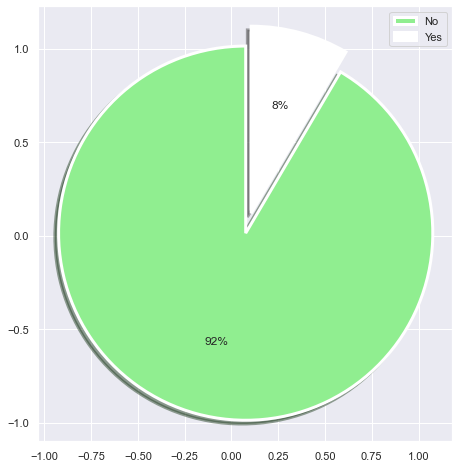

In [74]:
plot_pie(df = df,  column = 'HeartDisease', 
             explode = [0.09, 0.02], title = 'Heart Disease',
         colours = random.choices(list(mcolors.CSS4_COLORS.values()),k = 5))

#### How early or late do people with heart disease sleep?

#### Bed time and Heart Disease

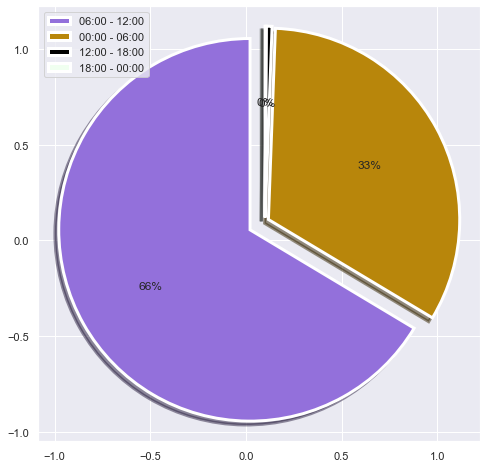

In [75]:
plot_pie(df = df.loc[df['HeartDisease'] == 'Yes'],  column = 'sleep_time_bins', 
             explode = [0.09, 0.02, 0.02, 0.02], title = 'Bed time and Heart Disease',
         colours = random.choices(list(mcolors.CSS4_COLORS.values()),k = 5))

#### Do Concerns about mental, physical health increase the likelihood of heart disease

#### Concerns about mental, physical health and heart disease

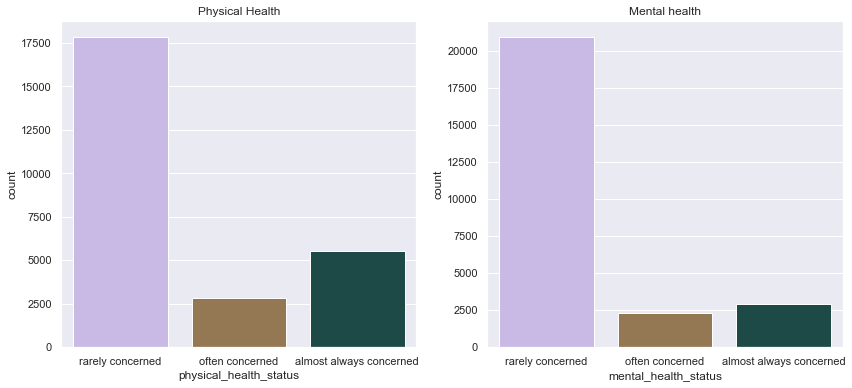

<Figure size 576x432 with 0 Axes>

In [76]:
display(Markdown('#### Concerns about mental, physical health and heart disease'))

f, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.figure(figsize = (8,6))

sns.countplot(x = 'physical_health_status', palette = 'cubehelix_r',
              data = df.loc[df['HeartDisease'] == 'Yes'], order = ['rarely concerned', 'often concerned', 
                                                                   'almost always concerned'],
              ax = axes[0]).set_title('Physical Health')

sns.countplot(x = 'mental_health_status', palette = 'cubehelix_r',
              data = df.loc[df['HeartDisease'] == 'Yes'], order = ['rarely concerned', 'often concerned', 
                                                                   'almost always concerned'],
              ax = axes[1]).set_title('Mental health')

plt.show()

#### Does physical activity increase the likelihood of heart disease?

### Physical activity and heart disease

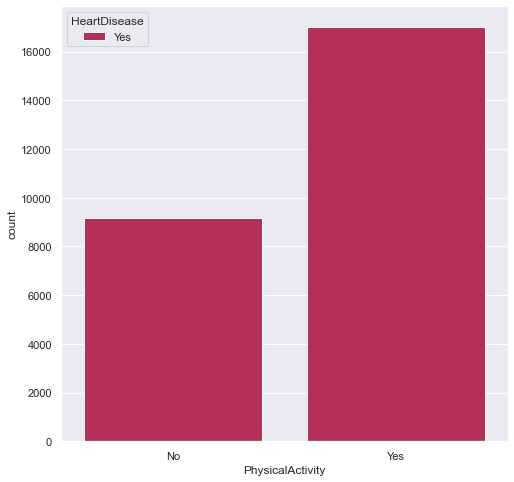

In [77]:
display(Markdown('### Physical activity and heart disease'))
plt.figure(figsize = (8,8))
sns.countplot(x = 'PhysicalActivity', hue = 'HeartDisease', data = df.loc[df['HeartDisease'] == 'Yes'], 
              palette = 'rocket_r')
plt.show()

#### What gender is likely to develop heart disease?

#### Gender and Heart Disease

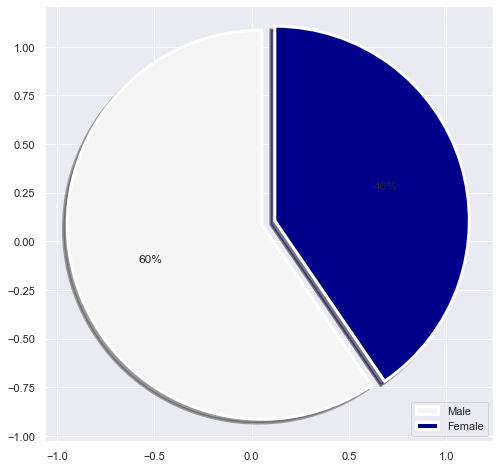

In [78]:
plot_pie(df = df.loc[df['HeartDisease'] == 'Yes'],  column = 'Sex', 
             explode = [0.05, 0.02], title = 'Gender and Heart Disease',
         colours = random.choices(list(mcolors.CSS4_COLORS.values()),k = 3))

#### At what ages do men and women mostly develop heart disease?

### Age, Gender and Heart Disease

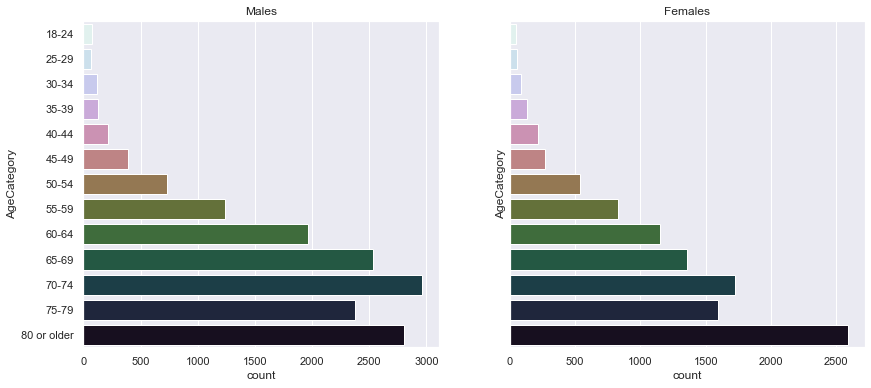

<Figure size 864x720 with 0 Axes>

In [79]:
display(Markdown('### Age, Gender and Heart Disease'))

f, axes = plt.subplots(1, 2, figsize=(14, 6), sharey = True)
plt.figure(figsize = (12,10))

sns.countplot(y = 'AgeCategory', palette = 'cubehelix_r', order = sorted(df['AgeCategory'].unique()),
              data = df.loc[(df['HeartDisease'] == 'Yes') & (df['Sex'] == 'Male')],
              ax = axes[0]).set_title('Males')

sns.countplot(y = 'AgeCategory', palette = 'cubehelix_r', order = sorted(df['AgeCategory'].unique()),
              data = df.loc[(df['HeartDisease'] == 'Yes') & (df['Sex'] == 'Female')],
              ax = axes[1]).set_title('Females')


plt.show()

#### Do smoking and alcohol usage increase the likelihood of heart disease?

### Smoking, Alcohol consumtion and Heart Disease

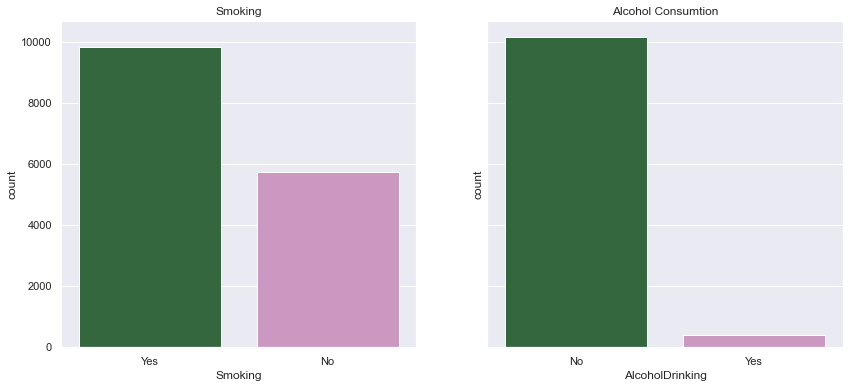

<Figure size 864x720 with 0 Axes>

In [80]:
display(Markdown('### Smoking, Alcohol consumtion and Heart Disease'))

f, axes = plt.subplots(1, 2, figsize=(14, 6), sharey = True)
plt.figure(figsize = (12,10))

sns.countplot(x = 'Smoking', palette = 'cubehelix',
              data = df.loc[(df['HeartDisease'] == 'Yes') & (df['Sex'] == 'Male')],
              ax = axes[0]).set_title('Smoking')

sns.countplot(x = 'AlcoholDrinking', palette = 'cubehelix',
              data = df.loc[(df['HeartDisease'] == 'Yes') & (df['Sex'] == 'Female')],
              ax = axes[1]).set_title('Alcohol Consumtion')


plt.show()

#### Does kidney disease or skin cancer lead to heart disease?

### Kidney Disease, Skin Cancer and Heart Disease

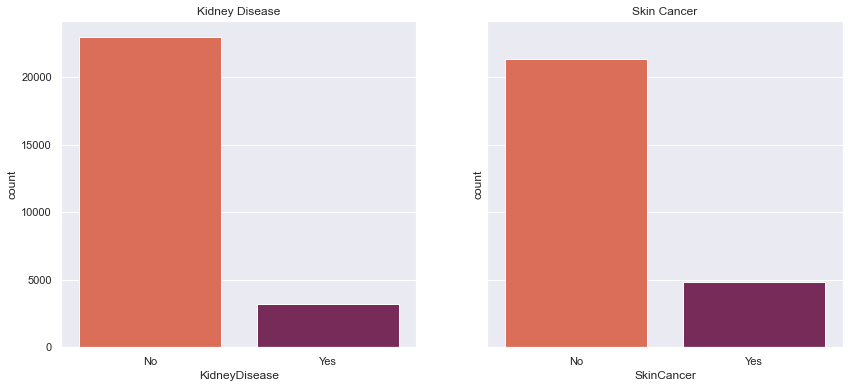

<Figure size 864x720 with 0 Axes>

In [81]:
display(Markdown('### Kidney Disease, Skin Cancer and Heart Disease'))

f, axes = plt.subplots(1, 2, figsize=(14, 6), sharey = True)
plt.figure(figsize = (12,10))

sns.countplot(x = 'KidneyDisease', palette = 'rocket_r',
              data = df.loc[df['HeartDisease'] == 'Yes'],
              ax = axes[0]).set_title('Kidney Disease')

sns.countplot(x = 'SkinCancer', palette = 'rocket_r',
              data = df.loc[df['HeartDisease'] == 'Yes'],
              ax = axes[1]).set_title('Skin Cancer')


plt.show()

#### What has BMI got to do with heart disease?

#### Weight and Heart Disease

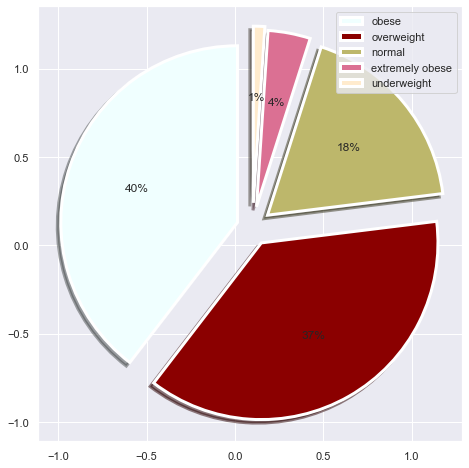

In [82]:
plot_pie(df = df.loc[df['HeartDisease'] == 'Yes'],  column = 'weight_status_by_bmi', 
             explode = [0.09, 0.10, 0.11, 0.12, 0.14], title = 'Weight and Heart Disease',
         colours = random.choices(list(mcolors.CSS4_COLORS.values()),k = 7))

#### Stroke and Heart Disease

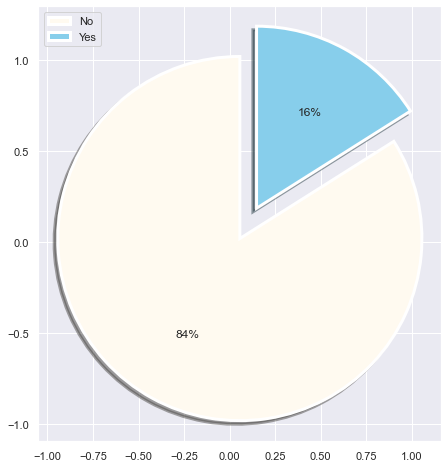

In [83]:
plot_pie(df = df.loc[df['HeartDisease'] == 'Yes'],  column = 'Stroke', 
             explode = [0.09, 0.10], title = 'Stroke and Heart Disease',
         colours = random.choices(list(mcolors.CSS4_COLORS.values()),k = 7))

#### Asthma and Heart Disease

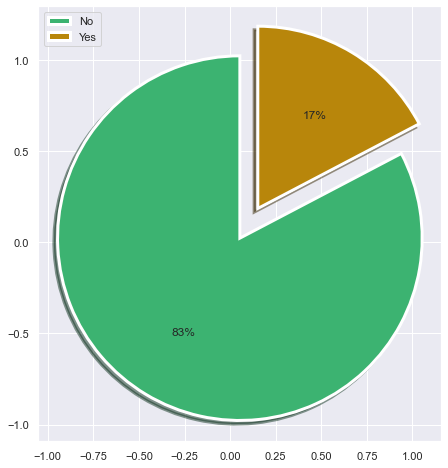

In [84]:
plot_pie(df = df.loc[df['HeartDisease'] == 'Yes'],  column = 'Asthma', 
             explode = [0.09, 0.10], title = 'Asthma and Heart Disease',
         colours = random.choices(list(mcolors.CSS4_COLORS.values()),k = 7))

## 3. Preprocessing and Modelling

Machine Learning algorithms do not work well with strings. so we need to convert strings to floats or integers. In ddoing so, we have to consider ordinal and nominal categorical types. 

Ordinal categories will be label encoded while nominal categories will be one hot encoded. 

We will also be dropping some unnecessary columns such as BMI, PhysicalHealth, MentalHealth	and SleepTime since we have discetized them previously. 

In [85]:
cols_to_drop = ['PhysicalHealth', 'MentalHealth', 'BMI', 'SleepTime']
df.drop(cols_to_drop, axis = 1, inplace = True)

x = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

In [86]:
# --- identifying nominal and ordinal columns

nominal_columns = ['Sex', 'Race']

ordinal_columns = ['Smoking','AlcoholDrinking','AgeCategory','Stroke','DiffWalking','PhysicalActivity',
 'GenHealth', 'Asthma','KidneyDisease','SkinCancer','weight_status_by_bmi','physical_health_status',
 'mental_health_status','sleep_time_bins']

In [87]:
# --- encoding nominal columns

one_hot_encoder.fit(x[nominal_columns])
ohe_columns = one_hot_encoder.transform(x[nominal_columns]).toarray()
ohe_columns = pd.DataFrame(ohe_columns,
                         columns = one_hot_encoder.get_feature_names_out())
ohe_columns.head() 

,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [88]:
# ---  encoding ordinal columns

ordinal_encoder.fit(x[ordinal_columns])
oe_columns = pd.DataFrame(ordinal_encoder.transform(x[ordinal_columns]), columns = ordinal_encoder.feature_names_in_)
oe_columns.head()

,Smoking,AlcoholDrinking,AgeCategory,Stroke,DiffWalking,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer,weight_status_by_bmi,physical_health_status,mental_health_status,sleep_time_bins
0,1.0,0.0,7.0,0.0,0.0,1.0,4.0,1.0,0.0,1.0,4.0,2.0,0.0,0.0
1,0.0,0.0,12.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0
2,1.0,0.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0
3,0.0,0.0,11.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,3.0,2.0,2.0,0.0
4,0.0,0.0,4.0,0.0,1.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [89]:
# --- label encoding y variables

LabelEncoder.fit(y)
y_transformed = LabelEncoder.transform(y)


In [90]:
# --- merging preprocessing results

x_transformed = pd.concat([ohe_columns, oe_columns], axis = 1)

### Before we Proceed

From our EDA, we see that the dataset is significantly imbalanced, we need to balance it with imblearn

In [91]:
x_resampled, y_resampled = class_balancer.fit_resample(x_transformed, y_transformed)

In [92]:
# --- splitting the data into train and test for evaluation

x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, 
                                                   test_size = 0.2, stratify = y_resampled)

In [93]:
def compute_metrics(model, x_train, x_test, y_train, y_test, y_pred):
    
    print('training_score:', model.score(x_train, y_train))
    print('testing_score:', model.score(x_test, y_test))
    print('difference between train and test score:', model.score(x_train, y_train) - model.score(x_test, y_test))
    print('precision_score:', precision_score(y_test, y_pred))
    print('recall_score:', recall_score(y_test, y_pred))
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

### Benchmarking 

#### RandomForestClassifier based model

training_score: 0.8804040305958061
testing_score: 0.863784823982204
difference between train and test score: 0.016619206613602056
precision_score: 0.8374355195283714
recall_score: 0.9028282899615127


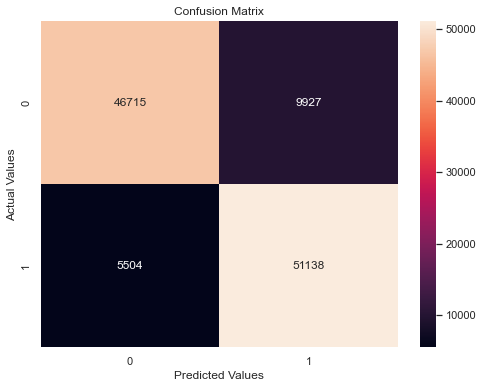

#### GradientBoostingClassifier based model

training_score: 0.7654292107853307
testing_score: 0.7649094311641538
difference between train and test score: 0.0005197796211768857
precision_score: 0.7478035407583564
recall_score: 0.7994244553511528


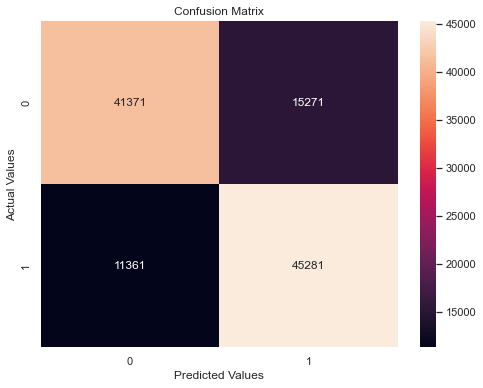

#### LogisticRegression based model

training_score: 0.7473550870162027
testing_score: 0.7477313654178878
difference between train and test score: -0.00037627840168508175
precision_score: 0.741041673824166
recall_score: 0.7616079940680061


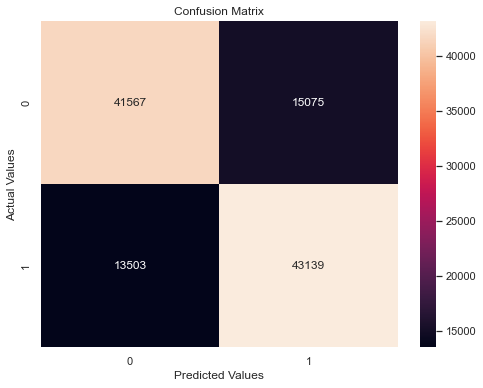

#### DecisionTreeClassifier based model

training_score: 0.8804040305958061
testing_score: 0.8575085625507574
difference between train and test score: 0.022895468045048717
precision_score: 0.8293968377903572
recall_score: 0.9001800783870626


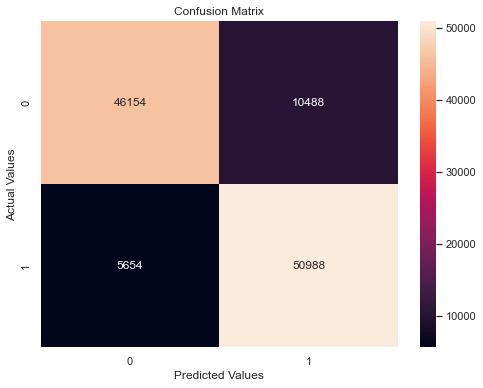

In [94]:
for clf in [rfc_clf, gbc_clf, log_reg, dt_clf]:
    algorithm_name = clf.__class__.__name__
    display(Markdown('#### {} based model'.format(algorithm_name)))

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    compute_metrics(clf, x_train, x_test, y_train, y_test, y_pred)


### Feature Importance

The random forest classifier performed best, now it's time to ascertain the feature importance

In [95]:
# def feature_imp(x_train_set, model = 'model name', num_of_feats = 'number'):
#     feature_importance = pd.DataFrame(model.feature_importances_,index=x_train_set.columns.tolist(),
#                                       columns=['feat_imp']).reset_index()
#     feature_importance.rename(columns={'index': 'feature'}, inplace=True)
#     feature_importance['rate'] = np.round((feature_importance['feat_imp']/feature_importance['feat_imp'].sum())*100,2)
#     feature_importance = feature_importance.sort_values(by=['rate'], ascending=False).reset_index(drop=True)
#     feature_importance.drop(columns=['feat_imp'],inplace=True)
#     fig, ax = plt.subplots(figsize=(10, 10),nrows=1,ncols=1)
#     sns.barplot(x=feature_importance.loc[0:num_of_feats,'rate'], 
#                 y=feature_importance.loc[0:num_of_feats,'feature'], 
#                 palette = 'rocket', data=feature_importance)
#     plt.xlabel('Percentage')
#     plt.ylabel('Feature')
#     plt.title('Top {} important features'.format(num_of_feats))
#     plt.show()
    
# feature_imp(x_train, model = rfc_clf, num_of_feats = 15)

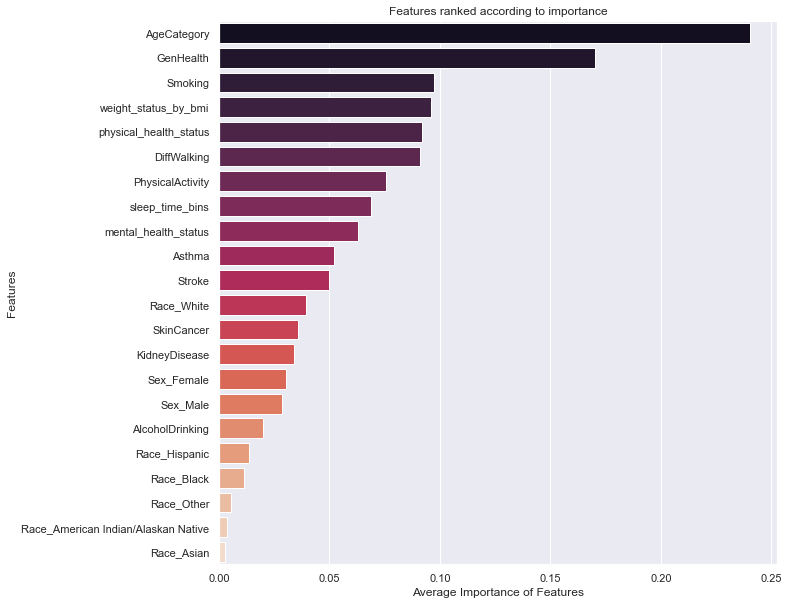

In [99]:
def feature_imp(x_train, x_test, y_test, model = rfc_clf):
    
    r = permutation_importance(model, x_test, y_test, n_repeats = 10, random_state = 0)
    feature_importance = pd.DataFrame(columns = ['avg_imp', 'std_imp'], index = [i for i in x_train.columns])
    feature_importance['avg_imp'] = r.importances_mean
    feature_importance['std_imp'] = r.importances_std
    
    feature_importance = feature_importance.sort_values(by=['avg_imp'], ascending=False).reset_index()
    feature_importance = feature_importance.rename(columns = {'index':'features'})
    fig, ax = plt.subplots(figsize=(10, 10),nrows=1,ncols=1)

    sns.barplot(x='avg_imp', 
                y='features', 
                palette = 'rocket', data = feature_importance)
    plt.xlabel('Average Importance of Features')
    plt.ylabel('Features')
    plt.title('Features ranked according to importance')
    plt.show()


feature_imp(x_train, x_test, y_test, model = rfc_clf)

### Model Calibration

#### Calibration Plot of Random Forest Classifier

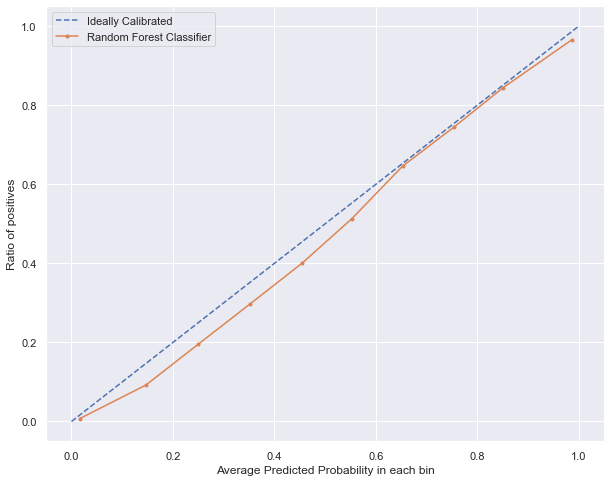

In [100]:
y_pred_proba = rfc_clf.predict_proba(x_test)

def plot_calibration_curve(y_val, y_proba, bins = 10, model_name = 'string'):
    
    """
    Function to plot calibration curve of model
    
    parameters
    -----------
    y_val: Actual labels in test set
    y_proba: predicted probabilities of model
    bins: number of bins 
    model_name: name of model
    
    returns
    ----------
    calibration curve plot 
    """
    
    x, y = calibration_curve(y_val, y_proba, n_bins = bins, normalize = True)
    
    plt.figure(figsize = (10,8))
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')

    plt.plot(y, x, marker = '.', label = model_name)

    leg = plt.legend(loc = 'upper left')

    display(Markdown('#### Calibration Plot of {}'.format(model_name)))

    plt.xlabel('Average Predicted Probability in each bin')
    plt.ylabel('Ratio of positives')
    plt.show()


plot_calibration_curve(y_test, y_pred_proba[:, 1], bins = 10, model_name = 'Random Forest Classifier')

### Building Model Pipeline

In [101]:
transformer = ColumnTransformer([('onehotencoding', one_hot_encoder, nominal_columns),
                                ('ordinal_encoding', ordinal_encoder, ordinal_columns)])

transformer.fit(df.drop('HeartDisease', axis = 1))

rfc_pipeline = Pipeline([('transform_variables', transformer),
                        ('make_predictions', rfc_clf)])

rfc_pipeline

Pipeline(steps=[('transform_variables',
                 ColumnTransformer(transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Race']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'AgeCategory', 'Stroke',
                                                   'DiffWalking',
                                                   'PhysicalActivity',
                                                   'GenHealth', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer',
                                                   'weight_status_by_bmi',
                                                   'physical_health_status',
                                                   'mental_health_status',
                                                   'sleep_time_bins'])])),
                ('make_predictions', RandomForestClassifier(random_state=42))])